In [1]:
import numpy as np
import pandas as pd
import os
import sys
sys.path.append('/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/src/')
from feature_transformation import parse_feature_cols
import json
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from autograd.scipy.special import expit as ag_expit
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

## Generate Toy Data

In [3]:
P = 3
n_P = [30, 60, 30]  
pos_random_state=101
neg_random_state=201
mu_PD = np.asarray([
    [0.7, 2.5],
    [0.7, 1.0],
    [0.7, 0.0]])
cov_PDD = np.vstack([
    np.diag([0.06, 0.1])[np.newaxis,:],
    np.diag([0.1, 0.1])[np.newaxis,:],
    np.diag([0.06, 0.06])[np.newaxis,:],
    ])

prng = np.random.RandomState(int(pos_random_state))
xpos_list = list()
for p in range(P):
    x_ND = prng.multivariate_normal(mu_PD[p], cov_PDD[p], size=n_P[p])
    xpos_list.append(x_ND)
x_pos_ND = np.vstack(xpos_list)
y_pos_N  = np.ones(x_pos_ND.shape[0])

# Generate negative data from 3 blobs
P = 3
n_P = [400, 30, 20]
mu_PD = np.asarray([
    [2.25, 1.5],
    [0.0, 3.0],
    [0.0, 0.5],
    ])
cov_PDD = np.vstack([
    np.diag([.1, .2])[np.newaxis,:],
    np.diag([.05, .05])[np.newaxis,:],
    np.diag([.05, .05])[np.newaxis,:],
    ])

prng = np.random.RandomState(int(neg_random_state))
xneg_list = list()
for p in range(P):
    x_ND = prng.multivariate_normal(mu_PD[p], cov_PDD[p], size=n_P[p])
    xneg_list.append(x_ND)
x_neg_ND = np.vstack(xneg_list)
y_neg_N = np.zeros(x_neg_ND.shape[0])

# Aggregate the positive and negative data together
x_ND = np.vstack([x_pos_ND, x_neg_ND])
y_N = np.hstack([y_pos_N, y_neg_N])

# Standardize the data
# x_ND = (x_ND - np.mean(x_ND, axis=0))/np.std(x_ND, axis=0)
x_pos_ND = x_ND[y_N == 1]
x_neg_ND = x_ND[y_N == 0]
    
    
prng = np.random.RandomState(0)
shuffle_ids = prng.permutation(y_N.size)
N_train = int(len(shuffle_ids)*0.9)
N_valid = int(len(shuffle_ids)*0.05)
N_test = int(len(shuffle_ids)*0.05)
train_x_ND = x_ND[shuffle_ids[:N_train]]
train_y_N = y_N[shuffle_ids[:N_train]]

valid_x_ND = x_ND[shuffle_ids[N_train:N_train+N_valid]]
valid_y_N = y_N[shuffle_ids[N_train:N_train+N_valid]]

test_x_ND = x_ND[shuffle_ids[N_train+N_valid:N_train+N_valid+N_test]]
test_y_N = y_N[shuffle_ids[N_train+N_valid:N_train+N_valid+N_test]]

In [4]:
train_y_N.sum()/len(train_y_N)

0.2046783625730994

In [5]:
N_train+N_valid+N_test

569

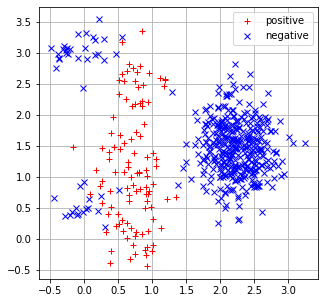

(-3.0, 3.0)

In [6]:
f, axs = plt.subplots(1, 1, figsize=(5,5))

train_x_pos_ND = train_x_ND[train_y_N==1]
train_x_neg_ND = train_x_ND[train_y_N==0]
axs.plot(train_x_pos_ND[:,0], train_x_pos_ND[:,1], 'r+', label='positive')
axs.plot(train_x_neg_ND[:,0], train_x_neg_ND[:,1], 'bx', label='negative')
axs.grid(True)
axs.legend()
plt.show()
axs.set_xlim([-3, 3])

## Get the EICU data

In [7]:
eicu_data_dir = '/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/datasets/eicu/v20210610/split-by=subject_id/collapsed_features_dynamic_input_output/classifier_train_test_split_dir/'
eicu_data_csv = os.path.join(eicu_data_dir, 'x_train.csv')
eicu_df = pd.read_csv(eicu_data_csv)

eicu_dict_file = os.path.join(eicu_data_dir, 'x_dict.json')
eicu_data_dict = json.load(open(eicu_dict_file))
feature_cols = parse_feature_cols(eicu_data_dict['schema'])


In [8]:
eicu_df

,subject_id,hadm_id,icustay_id,start,stop,BUN_std_90-100,BUN_time_since_measured_90-100,BUN_count_90-100,BUN_slope_90-100,BUN_median_90-100,...,st2_max_0-100,st2_last_value_measured_0-100,st3_std_0-100,st3_time_since_measured_0-100,st3_count_0-100,st3_slope_0-100,st3_median_0-100,st3_min_0-100,st3_max_0-100,st3_last_value_measured_0-100
0,002-10052,137239,151900,-24.0,-12.0,10.0,-24.0,0.0,0.0,0.0,...,0.0,0.0,10.000000,-24.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,002-10052,137239,151900,-24.0,0.0,10.0,-24.0,0.0,0.0,0.0,...,0.0,0.0,10.000000,-24.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,002-10052,137239,151900,-24.0,12.0,10.0,-24.0,0.0,0.0,0.0,...,0.0,0.0,10.000000,-24.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,002-10052,137239,151900,-24.0,24.0,0.0,3.0,1.0,0.0,15.0,...,0.0,0.0,10.000000,-24.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,002-10052,137239,151900,-24.0,36.0,0.0,0.0,1.0,0.0,16.0,...,0.0,0.0,10.000000,-24.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428704,035-9975,2731781,3340712,-24.0,84.0,0.0,8.0,1.0,0.0,30.0,...,190.0,75.0,23.037580,2.0,76.0,0.145142,30.0,0.0,110.0,30.0
428705,035-9975,2731781,3340712,-24.0,96.0,10.0,-24.0,0.0,0.0,0.0,...,190.0,90.0,22.899347,0.0,87.0,0.243083,30.0,0.0,110.0,60.0
428706,035-9975,2731781,3340712,-24.0,108.0,0.0,8.0,1.0,0.0,31.0,...,190.0,90.0,22.629614,0.0,96.0,0.263282,30.0,0.0,110.0,50.0
428707,035-9975,2731781,3340712,-24.0,120.0,10.0,-24.0,0.0,0.0,0.0,...,190.0,65.0,23.196384,0.0,108.0,0.062871,30.0,0.0,110.0,50.0


## Merge to create semi-synthetic data

In [9]:
eicu_data_np = eicu_df[feature_cols].values
prng = np.random.RandomState(0)
shuffle_ids_eicu = prng.permutation(eicu_data_np.shape[0])

shuffle_ids_eicu_train = shuffle_ids_eicu[:N_train]
shuffle_ids_eicu_valid = shuffle_ids_eicu[N_train:N_train+N_valid]
shuffle_ids_eicu_test = shuffle_ids_eicu[N_train+N_valid:N_train+N_valid+N_test]

train_x_final = np.hstack([train_x_ND, eicu_data_np[shuffle_ids_eicu_train]])
valid_x_final = np.hstack([valid_x_ND, eicu_data_np[shuffle_ids_eicu_valid]])
test_x_final = np.hstack([test_x_ND, eicu_data_np[shuffle_ids_eicu_test]])

## Throw into dataframe and save to csv

In [10]:
final_feature_cols = ['synthetic_0', 'synthetic_1']+feature_cols
outcome_col = ['synthetic_outcome']

In [11]:
n_features = 100

final_x_train_df = pd.DataFrame(train_x_final[:, :n_features], columns=final_feature_cols[:n_features])
final_y_train_df = pd.DataFrame(train_y_N.astype(int), columns=outcome_col)

final_x_valid_df = pd.DataFrame(valid_x_final[:, :n_features], columns=final_feature_cols[:n_features])
final_y_valid_df = pd.DataFrame(valid_y_N.astype(int), columns=outcome_col)

final_x_test_df = pd.DataFrame(test_x_final[:, :n_features], columns=final_feature_cols[:n_features])
final_y_test_df = pd.DataFrame(test_y_N.astype(int), columns=outcome_col)

In [12]:
final_x_train_df

,synthetic_0,synthetic_1,BUN_count_0-100,BUN_count_90-100,BUN_last_value_measured_0-100,BUN_last_value_measured_90-100,BUN_max_0-100,BUN_max_90-100,BUN_median_0-100,BUN_median_90-100,...,gender_is_male_min_0-100,gender_is_male_min_90-100,gender_is_male_slope_0-100,gender_is_male_slope_90-100,gender_is_male_std_0-100,gender_is_male_std_90-100,gender_is_male_time_since_measured_0-100,gender_is_male_time_since_measured_90-100,gender_is_unknown_count_0-100,gender_is_unknown_count_90-100
0,1.890869,1.846822,2.0,1.0,12.0,12.0,22.0,12.0,17.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,9.0
1,2.304223,0.964462,13.0,1.0,32.0,32.0,83.0,32.0,57.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,10.0
2,2.063991,1.828206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,10.0,-24.0,-24.0,0.0,0.0
3,2.145149,1.076520,2.0,1.0,16.0,16.0,16.0,16.0,14.5,16.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,4.0
4,1.004040,0.322889,1.0,0.0,12.0,0.0,12.0,0.0,12.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,2.438418,2.668087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
509,2.016017,1.798894,2.0,0.0,18.0,0.0,25.0,0.0,21.5,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,7.0
510,2.266174,0.323812,1.0,0.0,21.0,0.0,21.0,0.0,21.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,9.0
511,-0.299949,3.109215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,10.0,-24.0,-24.0,0.0,0.0


In [13]:
final_y_train_df

,synthetic_outcome
0,0
1,0
2,0
3,0
4,1
...,...
508,0
509,0
510,0
511,0


In [14]:
semi_synthetic_dir = '/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/datasets/semi_synthetic_precision_recall_eicu/'
x_train_csv = os.path.join(semi_synthetic_dir, 'x_train.csv')
y_train_csv = os.path.join(semi_synthetic_dir, 'y_train.csv')

x_valid_csv = os.path.join(semi_synthetic_dir, 'x_valid.csv')
y_valid_csv = os.path.join(semi_synthetic_dir, 'y_valid.csv')

x_test_csv = os.path.join(semi_synthetic_dir, 'x_test.csv')
y_test_csv = os.path.join(semi_synthetic_dir, 'y_test.csv')

final_x_train_df.to_csv(x_train_csv, index=False)
final_y_train_df.to_csv(y_train_csv, index=False)

final_x_valid_df.to_csv(x_valid_csv, index=False)
final_y_valid_df.to_csv(y_valid_csv, index=False)

final_x_test_df.to_csv(x_test_csv, index=False)
final_y_test_df.to_csv(y_test_csv, index=False)

In [15]:
final_x_train_df.shape

(513, 100)

In [16]:
final_x_valid_df.shape

(28, 100)

In [17]:
final_x_test_df.shape

(28, 100)

In [18]:
final_y_train_df['synthetic_outcome'].sum()*100/len(final_y_train_df)

20.46783625730994

In [19]:
final_y_valid_df['synthetic_outcome'].sum()*100/len(final_y_valid_df)

32.142857142857146

In [20]:
final_y_test_df['synthetic_outcome'].sum()*100/len(final_y_test_df)

21.428571428571427

In [27]:
def calc_cross_entropy_loss(w_D):  
    ry_N = np.sign(y_N-0.01)*(np.dot(x_ND, w_D[:2]) + w_D[2])
    cross_ent = np.sum(np.log(ag_expit(ry_N)+1e-15))# add 1e-15 to avoid precision problems
    return -1.0*cross_ent

def calc_decision_score(x, w):
    return np.dot(x, w[:2]) + w[2]

def pretty_plot_of_decision_boundary(
        w_D, level_grid = [-1.0, 0.0, 1.0],
        G=51, H=51, figsize=(3,3),
        x1_lims=(-2, 6), x2_lims=(-2, 6), title_str='', thresh=0.0): 


    redblue_colors = plt.cm.RdBu(np.linspace(0, 1, 101))
    redblue_cmap = matplotlib.colors.ListedColormap(redblue_colors)
    redblue_cmap_r = matplotlib.colors.ListedColormap(redblue_cmap.colors[::-1])
    
    fig, ax_h = plt.subplots(figsize=figsize)
    sns.set_context("notebook", font_scale=1.5)
    divider = make_axes_locatable(ax_h)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    ax_h.set_xlim(x1_lims)
    ax_h.set_ylim(x2_lims)

    ax_h.plot(x_neg_ND[:,0], x_neg_ND[:,1], 'x', color=redblue_colors[-1])
    ax_h.plot(x_pos_ND[:,0], x_pos_ND[:,1], '+', color=redblue_colors[0])
    ax_h.set_xlabel(r'$x_1$')
    ax_h.set_ylabel(r'$x_2$')
    w_str = ' '.join(['% .2f' % a for a in w_D])
    
    x0_G = np.linspace(*ax_h.get_xlim(), num=G)
    x1_H = np.linspace(*ax_h.get_ylim(), num=H)
    G = x0_G.size
    H = x1_H.size
    
    # J = G * H
    X0_HG, X1_HG = np.meshgrid(x0_G, x1_H)
    assert X0_HG.shape == (H, G)
    x_JD = np.hstack([X0_HG.flatten()[:,np.newaxis], X1_HG.flatten()[:,np.newaxis]])
    assert np.allclose(X0_HG, x_JD[:,0].reshape((H,G)))
    
    z_J = calc_decision_score(x_JD, w_D)
    Z_HG = z_J.reshape((H,G))

    B_HG = 2.0 * (Z_HG > 0) - 1.0
    
    L = np.maximum(len(level_grid), 11)
    level_colors = plt.cm.Greys(np.linspace(0, 1, L))

    # Get grays in the middle range
    m = L // 2
    nrem = len(level_grid)
    mlow = m - nrem // 2
    mhigh = m + nrem // 2 + 1
    if mhigh - mlow < len(level_grid):
        mhigh += 1
    print(mlow, mhigh, L)
    level_cmap = matplotlib.colors.ListedColormap(level_colors[mlow:mhigh])
        
    ax_h.contour(
        X0_HG, X1_HG, Z_HG,
        levels=level_grid,
        cmap=level_cmap,
        vmin=-5, vmax=+5);
    im = ax_h.pcolormesh(
        X0_HG, X1_HG, ag_expit(Z_HG),
        alpha=1.0, linewidth=0,
        cmap=redblue_cmap_r,
        edgecolor='face', vmin=0.0, vmax=1.0);
    #im.set_edgecolor((1.0, 1.0, 1.0, 0.001))
    im.set_linewidth(0.0)
    im.set_alpha(0.25)

    cbar = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8])
    cbar.set_alpha(0.25)
    cbar.draw_all()

    z_N = calc_decision_score(x_ND, w_D)
    yhat_N = np.float64(z_N >= thresh)
    TP = np.sum(np.logical_and(y_N == 1, yhat_N == 1))
    FP = np.sum(np.logical_and(y_N == 0, yhat_N == 1))
    TN = np.sum(np.logical_and(y_N == 0, yhat_N == 0))
    FN = np.sum(np.logical_and(y_N == 1, yhat_N == 0))
    precision = TP / (1e-10 + float(TP+FP))
    recall = TP / (1e-10 + float(TP + FN))

    ax_h.set_title("%s\n Prec:%.3f  Rec:%.3f  CE:% .1f\n" % (
        title_str, precision, recall, calc_cross_entropy_loss(w_D)))
    ax_h.set_xticks(np.linspace(x1_lims[0], x1_lims[1]), 10)
    ax_h.set_yticks(np.linspace(x2_lims[0], x2_lims[1]), 10)
    
    
    #print("w_D: %s" % (str(w_D)))
    for level_thr in level_grid:
        # Assess each training point at this level
        z_N = calc_decision_score(x_ND, w_D)
        yhat_N = np.float64(z_N >= level_thr)
        TP = np.sum(np.logical_and(y_N == 1, yhat_N == 1))
        FP = np.sum(np.logical_and(y_N == 0, yhat_N == 1))
        TN = np.sum(np.logical_and(y_N == 0, yhat_N == 0))
        FN = np.sum(np.logical_and(y_N == 1, yhat_N == 0))
        precision = TP / (1e-10 + float(TP+FP))
        recall = TP / (1e-10 + float(TP + FN))
        print("thr % 6.3f | cross_entropy %.3f | precision %.3f | recall %.3f | TP %5d | FP %5d | TN %5d | FN %5d" % (
            level_thr, 
            calc_cross_entropy_loss(w_D),
            precision, recall, TP, FP, TN, FN))

5 6 11
thr  0.000 | cross_entropy 99840.642 | precision 0.916 | recall 0.042 | TP   839 | FP    77 | TN 404923 | FN 19161


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


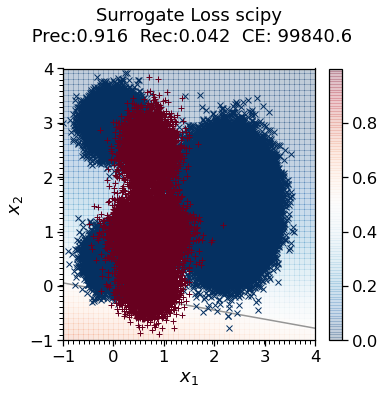

In [61]:
opt_w_D_sl_tight_90_scipy = np.array([-0.15, -0.9, -0.1])
pretty_plot_of_decision_boundary(opt_w_D_sl_tight_90_scipy, level_grid = [0.0],
                                 figsize=(5,5), x1_lims=(-1, 4), x2_lims=(-1, 4), title_str='Surrogate Loss scipy')